In [1]:
import os
import glob
import pickle

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#from car_detect_util import *
#from utils import *

import time
from moviepy.editor import VideoFileClip

import numpy as np
import cv2
import copy
from scipy import ndimage as ndi
from skimage.feature import hog

In [2]:
#########################
#DRAWING RECTANGLE BOXES#
#########################
def draw_boxes(img, bounding_boxes, color=(255, 0, 0), thick=6):

    imcopy = np.copy(img)
    for bbox in bounding_boxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

def extract_features(img_paths, parameters):
    features = []
    for file in img_paths:
        image = mpimg.imread(file)
        if np.max(image) > 1:
            image = image.astype(np.float32) / float(np.max(image))

        # Extract the features of each image
        features.append(single_img_features(image, parameters))

    return features


def get_windows(img, x_range=(None, None), y_range=(None, None),
                window_size=(64, 64), overlap=(0.5, 0.5)):
    # If the X or Y range is a None, set it to the min / max size of the image
    x_range = (
        x_range[0] if x_range[0] is not None else 0,
        x_range[1] if x_range[1] is not None else img.shape[1],
    )
    y_range = (
        y_range[0] if y_range[0] is not None else 0,
        y_range[1] if y_range[1] is not None else img.shape[0],
    )

    # Compute the span of the region to be searched
    x_span = x_range[1] - x_range[0]
    y_span = y_range[1] - y_range[0]

    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(window_size[0] * (1 - overlap[0]))
    ny_pix_per_step = np.int(window_size[1] * (1 - overlap[1]))

    # Compute the number of windows in x/y
    nx_windows = np.int(x_span / nx_pix_per_step) - 1
    ny_windows = np.int(y_span / ny_pix_per_step) - 1

    # Initialize a list to append window positions to
    window_list = []

    # Find the windows
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            x_start = xs * nx_pix_per_step + x_range[0]
            x_end = x_start + window_size[0]
            y_start = ys * ny_pix_per_step + y_range[0]
            y_end = y_start + window_size[1]

            # Append window position to list
            window_list.append(((x_start, y_start), (x_end, y_end)))

    return window_list


def find_cars(img, windows, clf, feature_scaler, parameters):
    result = []
    for window in windows:
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        features = single_img_features(test_img, parameters)

        test_features = feature_scaler.transform(np.array(features).reshape(1, -1))
        prediction = clf.predict(test_features)
        conf = clf.decision_function(test_features)
        if prediction == 1 and conf > 0.4:
            result.append(window)

    return result

def create_heatmap(windows, image_shape):
    heatmap = np.zeros(image_shape[:2])
    for window in windows:
        heatmap[window[0][1]:window[1][1], window[0][0]:window[1][0]] += 1
    return heatmap

# Show it
def show_images(img, img2):    
    fig = plt.figure()
    fig.add_subplot(221), plt.imshow(img), plt.title('Image 1')
    fig.add_subplot(222), plt.imshow(img2), plt.title('Image 2')
    plt.show()
    
def show_image(img):    
    img = cv2.imread('messi5.jpg',0)
    plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

def _get_hog_features(img, orient, pix_per_cell, cell_per_block, visualize=False, feature_vec=True):
    if visualize:
        # Call with two outputs if visualize==True
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=visualize, feature_vector=feature_vec)
        
        show_images(img, hog_image)
        
        return features, hog_image
    else:
        # Otherwise call with one output
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=visualize, feature_vector=feature_vec)
        return features


def _get_spatial_features(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel()
    return features


def _get_color_features(img, nbins=32, bins_range=(0, 256)):
    
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins, range=bins_range)

    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))

    return hist_features


def single_img_features(img, parameters):
    img_features = []

    # apply color conversion if other than 'RGB'
    feature_image = np.copy(img)
    if parameters['color_space'] != 'RGB':
        if parameters['color_space'] == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif parameters['color_space'] == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif parameters['color_space'] == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif parameters['color_space'] == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif parameters['color_space'] == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

    if parameters['spatial_enabled']:
        # Compute the spatial features if it's required
        img_features.append(_get_spatial_features(feature_image, size=parameters['spatial_size']))
    if parameters['color_hist_enabled']:
        # Compute the color histogram features if required
        img_features.append(_get_color_features(feature_image, nbins=parameters['color_hist_bins']))
    if parameters['hog_enabled']:
        # Compute the HOG features if requiread
        hog_features = []
        for channel in parameters['hog_channel']:
            hog_features.extend(_get_hog_features(feature_image[:, :, channel], parameters['hog_orientations'],
                                                  parameters['hog_pix_per_cell'], parameters['hog_cell_per_block'],
                                                  visualize=False, feature_vec=True))
        img_features.append(hog_features)

    return np.concatenate(img_features)


def find_windows_from_heatmap(image, threshold=0):
    """
    Finds a unified window from a heatmap
    :param image: The heatmap image
    :param threshold: The threshold to be used
    :return: Returns a list of windows
    """
    hot_windows = []

    # Threshold the image
    image[image <= threshold] = 0

    # Create labels
    labels = ndi.label(image)

    for car_number in range(1, labels[1] + 1):
        # Find pixels with each car_number label value
        non_zero = (labels[0] == car_number).nonzero()

        # Identify x and y values of those pixels
        non_zero_y = np.array(non_zero[0])
        non_zero_x = np.array(non_zero[1])

        # Define a bounding box based on min/max x and y
        hot_windows.append(((np.min(non_zero_x), np.min(non_zero_y)), (np.max(non_zero_x), np.max(non_zero_y))))

    return hot_windows


In [3]:
def plot_scaled_feature(imageArray, X, scaled_X):
    image_ind = np.random.randint(0, len(imageArray))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(imageArray[image_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[image_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[image_ind])
    plt.title('Normalized Features')
    fig.tight_layout()

In [4]:
def process_features():
    parameters = {'color_space': 'HSV',  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
                  'hog_orientations': 8,  # Number of orientations for HOG features
                  'hog_pix_per_cell': 8,  # Number of pixels per cell in HOG features
                  'hog_cell_per_block': 2,  # Number of cells per block in HOG features
                  'hog_channel': [1, 2],  # HOG features to be extracted from which channel
                  'spatial_size': (16, 16),  # Size of the spatial features
                  'color_hist_bins': 16,  # Number of color histogram bins
                  'spatial_enabled': True,  # If spatial features should be included
                  'color_hist_enabled': True,  # If color features should be included
                  'hog_enabled': True  # If HOG features should be included
                  }

    # Read the image paths
    cars = []
    not_cars = []

    cars_images = glob.glob('data/vehicles/*')
    for folder in cars_images:
        cars += glob.glob('{}/*.png'.format(folder))

    not_cars_images = glob.glob('data/non-vehicles/*')
    for folder in not_cars_images:
        not_cars += glob.glob('{}/*.png'.format(folder))

    print("Number of car samples:", len(cars))
    print("Number of non-car samples", len(not_cars))

    #show_images(cars_images[1], not_cars_images[1])
    carImage = mpimg.imread(cars[0])
    plt.imshow(carImage, cmap=plt.cm.Greys)
    
    # Extract the features for both the sets of data
    car_features = extract_features(cars, parameters)
    not_car_features = extract_features(not_cars, parameters)

    # Stack them together
    features = np.vstack((car_features, not_car_features)).astype(np.float64)

    # Scale and normalize the features
    scaler = StandardScaler().fit(features)
    scaled_features = scaler.transform(features)

    plot_scaled_feature(cars, features, scaled_features)
    
    # Define the labels vector
    targets = np.hstack((np.ones(len(car_features)), np.zeros(len(not_car_features))))

    # Split up data into randomized training and test sets
    features_train, features_test, targets_train, targets_test = train_test_split(
        scaled_features, targets, test_size=0.2, random_state=42)

    print('Feature vector length:', len(features_train[0]))

    # Save the data for easy access
    pickle_file = 'features.pickle'
    print('Saving data to pickle file - ', pickle_file)
    try:
        with open(pickle_file, 'wb') as pfile:
            pickle.dump(
                {
                    'features_train': features_train,
                    'targets_train': targets_train,
                    'features_test': features_test,
                    'targets_test': targets_test,
                    'scaler': scaler,
                    'parameters': parameters
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise


In [5]:
def train_classifier():
    # Reload the data
    pickle_file = 'features.pickle'
    with open(pickle_file, 'rb') as f:
        pickle_data = pickle.load(f)
        features_train = pickle_data['features_train']
        targets_train = pickle_data['targets_train']
        features_test = pickle_data['features_test']
        targets_test = pickle_data['targets_test']
        scaler = pickle_data['scaler']
        parameters = pickle_data['parameters']
        del pickle_data  # Free up memory

    print('Data and modules loaded.')
    print("train_features size:", features_train.shape)
    print("train_labels size:", targets_train.shape)
    print("test_features size:", features_test.shape)
    print("test_labels size:", targets_test.shape)
    for k in parameters:
        print(k, ":", parameters[k])

    # Use a linear SVC
    svc = LinearSVC() #max_iter=20000
    svc.fit(features_train, targets_train)

    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(features_test, targets_test), 4))

    # Save the model for easy access
    pickle_file = 'svc.pickle'
    print('Saving data to pickle file - ', pickle_file)
    try:
        with open(pickle_file, 'wb') as pfile:
            pickle.dump(
                {
                    'svc': svc,
                    'scaler': scaler,
                    'parameters': parameters
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

Use the existing features pickle file? (y/n):n
Number of car samples: 8792
Number of non-car samples 8968
Feature vector length: 3952
Saving data to pickle file -  features.pickle
Use the existing classification pickle file? (y/n):y


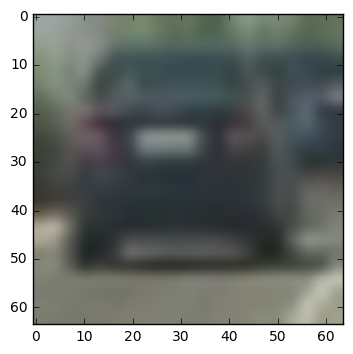

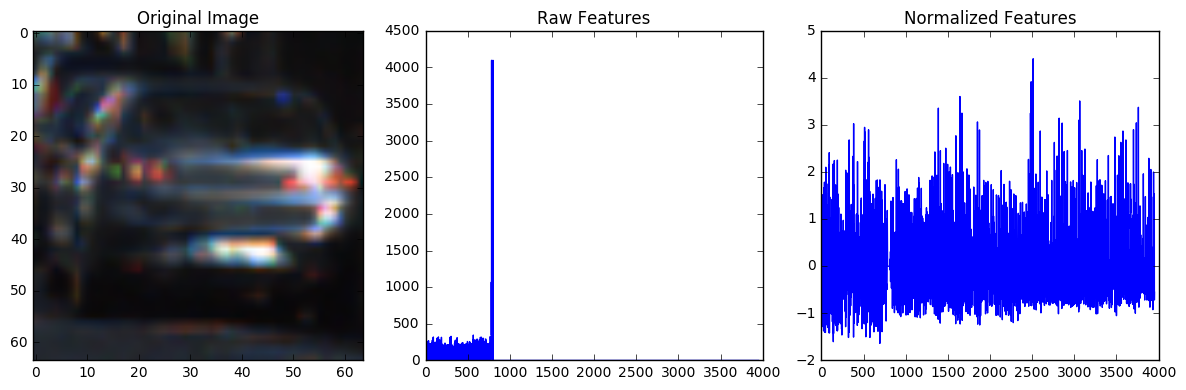

In [6]:
if __name__ == "__main__":
    # Check if a pickle file already exists
    if os.path.exists('features.pickle'):
        char = input('Use the existing features pickle file? (y/n):')
        if char == 'N' or char == 'n':
            process_features()
    else:
        process_features()
        
    # Check if a classifier picklt already exists
    if os.path.exists('svc.pickle'):
        char = input('Use the existing classification pickle file? (y/n):')
        if char == 'N' or char == 'n':
            train_classifier()
    else:
        train_classifier()

In [ ]:
class CarDetect:
    def __init__(self, classifier, scaler, parameters, displayResults=False):
        # Class parameters
        self.windows = None
        self.classifier = classifier
        self.scaler = scaler
        self.parameters = parameters

        # Size of the image
        self.img_size = None

        # Motion blur
        self.motion = None
        self.motion_idx = 0
        self.curr_motion_imgs = 0
        self.max_motion = 5
        self.old_boxes = []

        self.displayResults = displayResults

    # ----- Merging multiple frames for better detection ----- #
    def avg_frames(self, hot_windows):
        """
        Averages the detections across frames creating a motion blur if you will
        """
        # Find the heatmap for this image
        heatmap = create_heatmap(hot_windows, self.img_size)

        if self.motion is None:
            self.motion = np.zeros((self.max_motion, heatmap.shape[0], heatmap.shape[1]), dtype=np.float64)

        self.motion[self.motion_idx] = heatmap
        self.motion_idx += 1
        if self.motion_idx >= self.max_motion:
            self.motion_idx = 0
        self.curr_motion_imgs += 1
        if self.curr_motion_imgs > self.max_motion:
            self.curr_motion_imgs = self.max_motion

        return find_windows_from_heatmap(np.average(self.motion, axis=0),
                                         threshold=float(self.curr_motion_imgs / self.max_motion))
    
    # ----- Merging boxes across frames for better detection ---- #
    def blur_boxes(self, hot_windows, old_boxes,
                   image_shape):
        hot_boxes = self.__initialize_centers(hot_windows)
        new_boxes = self.link_boxes(hot_boxes, old_boxes)
        filtered_boxes = []

        # Find the new boxes that have a decent confidence (atleast one previous match)
        for new_box in new_boxes:
            if new_box[-1] > 2:
                filtered_boxes.append(new_box)

        # Converts the height width back into (x1, y1), (x2, y2)
        new_windows = []
        for filtered_box in filtered_boxes:
            new_center, new_width, new_height, new_move, new_prob = filtered_box
            new_windows.append(((int(new_center[0] - new_width), int(new_center[1] - new_height)),
                                (int(new_center[0] + new_width), int(new_center[1] + new_height))))

        # Create a heatmap
        heatmap = create_heatmap(new_windows, image_shape)

        # Check if there is any overlap of windows
        if np.unique(heatmap)[-1] >= 2:
            labels = ndi.label(heatmap)[0]
            threshold_heatmap = np.zeros_like(heatmap)
            threshold_heatmap[heatmap >= 2] = 1  # Threshold the heatmap
            threshold_labels = ndi.label(threshold_heatmap)  # Generate labels from the thresholded heatmap

            # Loop through all the labels
            for car_number in range(1, threshold_labels[1] + 1):
                nonzero = (threshold_labels[0] == car_number).nonzero()
                num = labels[nonzero[0][0], nonzero[1][0]]
                labels[labels == num] = 0
            heatmap = labels + threshold_heatmap
            new_windows = find_windows_from_heatmap(heatmap)

        return new_windows, new_boxes
    
    def execute(self, image):
        # Save the image size
        if self.img_size is None:
            self.img_size = image.shape

        # Form up the windows if it's not already
        if self.windows is None:
            self.windows = get_windows(image, x_range=(None, None), y_range=(400, 500),
                                       window_size=(96, 96), overlap=(0.75, 0.75))
            self.windows += get_windows(image, x_range=(None, None), y_range=(400, 500),
                                        window_size=(144, 144), overlap=(0.75, 0.75))
            self.windows += get_windows(image, x_range=(None, None), y_range=(430, 550),
                                        window_size=(192, 192), overlap=(0.75, 0.75))
            self.windows += get_windows(image, x_range=(None, None), y_range=(460, 580),
                                        window_size=(192, 192), overlap=(0.75, 0.75))

        # Normalize image
        norm = image.astype(np.float32) / 255

        # Get possible windows
        hot_windows = find_cars(norm, self.windows, self.classifier, self.scaler, self.parameters)

        # Average across multiple frames
        avg_windows = self.avg_frames(hot_windows)

        # Find an average width and length for the windows
        results, self.old_boxes = self.blur_boxes(avg_windows, self.old_boxes, image.shape)

        # Combine the windows to form a single window for each car
        avg_window_img = np.copy(image)
        avg_window_img = draw_boxes(avg_window_img, results)
        
        if self.displayResults == True:
            # Draw the raw windows
            raw_window_img = np.copy(image)
            raw_window_img = draw_boxes(raw_window_img, hot_windows)

            # Get the heatmap
            raw_heatmap = create_heatmap(hot_windows, image.shape)
            avg_heatmap = create_heatmap(avg_windows, image.shape)

            # Show it
            fig = plt.figure()
            fig.add_subplot(221), plt.imshow(raw_window_img), plt.title('Original')
            fig.add_subplot(222), plt.imshow(raw_window_img), plt.title('Raw Windows')
            fig.add_subplot(223), plt.imshow(raw_heatmap), plt.title('Heatmap')
            #fig.add_subplot(224), plt.imshow(avg_window_img), plt.title('Motion averaged Windows')
            fig.add_subplot(225), plt.imshow(avg_heatmap), plt.title('Motion averaged Heatmap')
            plt.show()

        return avg_window_img

    # ----- PRIVATE FUNCTIONS ----- #
    def eval_distance(self, a, b):
        """
        Calculates the distance between two points
        """
        return (a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2

    def __find_radius(self, box):
        """
        Find's the radius of the box
        """
        x_start, y_start = box[0]
        x_end, y_end = box[1]
        return (x_end - x_start) / 2, (y_end - y_start) / 2

    def __initialize_centers(self, boxes):
        """
        Initializes an array for the center / radius of the boxes
        :param boxes: A set of boxes (given by (x1, y1), (x2, y2)
        :return: A list of [(center, width, height, motion)]
        """
        result = []
        for box in boxes:
            center = self.eval_center(box)
            width, height = self.__find_radius(box)
            motion = (0, 0)  # motion of the center
            result.append((center, width, height, motion, 1))
        return result

    def eval_center(self, box):
        """
        Finds the center of a box
        """
        x_start, y_start = box[0]
        x_end, y_end = box[1]
        return (x_start + x_end) / 2.0, (y_start + y_end) / 2.0
    
    def is_near(self, old_center, new_center, old_width, new_width,
                  old_height, new_height):
        """
        Function to check if the old and new boxes are approximately close by
        :return: True / False
        """
        if self.eval_distance(old_center, new_center) < 5000 and abs(old_width - new_width) < 50 and \
                abs(old_height - new_height) < 50:
            return True
        else:
            return False

    def eval_centers_avg(self, new_center, old_center):
        """
        Simple weighted average of the centers
        """
        w = 2.  # weight parameter
        return ((new_center[0] + old_center[0] * w) / (w + 1),
                (new_center[1] + old_center[1] * w) / (w + 1))

    def link_boxes(self, new_boxes, old_boxes):
        """
        Function to search through the old and new boxes to find matches and then create
        a combined box list with confidences depending on how many matches we found
        """
        fresh_boxes = []
        max_confidence = 40
        temp_new_boxes = copy.copy(new_boxes)
        w = 3  # weight parameter

        # Loop over all old boxes and new boxes and find correlations (similar centers)
        for old_box in old_boxes:
            old_center, old_width, old_height, old_move, old_prob = old_box
            new_boxes = copy.copy(temp_new_boxes)
            if old_prob > 10:
                add_prob = 2
            else:
                add_prob = 1
            found = False
            fresh_box = None
            for new_box in new_boxes:
                new_center, new_width, new_height, new_move, new_prob = new_box
                if self.is_near(old_center, new_center, old_width, new_width, old_height, new_height):
                    fresh_box = [self.eval_centers_avg(new_center, old_center),
                                 (new_width + w * old_width) / (w + 1),
                                 (new_height + w * old_height) / (w + 1),
                                 self.eval_motion(new_center, old_center, old_move),
                                 min(max_confidence, old_prob + add_prob)]
                    # remove the new box from an array
                    temp_new_boxes.remove(new_box)
                    found = True
                    break
            # if no new_box is found, subtract the confidence by 1
            if not found:
                fresh_box = [self.motion_to_center(old_center, old_move), old_width, old_height, old_move, old_prob - 1]
            # add the fresh box
            fresh_boxes.append(fresh_box)
        # append the leftover new boxes to old boxes
        fresh_boxes += temp_new_boxes
        # delete if prob = 0
        temp_fresh_boxes = copy.copy(fresh_boxes)
        for box in fresh_boxes:
            if box[-1] <= 0:
                temp_fresh_boxes.remove(box)
        # return the updated old_boxes
        return temp_fresh_boxes
    
    def eval_motion(self, new_center, old_center, old_motion):
        """
        Calculates how much the center has moved based on a weighted equation
        """
        w = 6.  # weight parameter
        return ((new_center[0] - old_center[0] + w * old_motion[0]) / (w + 1),
                (new_center[1] - old_center[1] + w * old_motion[1]) / (w + 1))

    def motion_to_center(self, center, motion):
        """
        Adds the movement value to the center to correct the center of jitter
        """
        return center[0] + motion[0] / 5, center[1] + motion[1] / 5

In [ ]:
pickle_file = 'svc.pickle'
with open(pickle_file, 'rb') as f:
    pickle_data = pickle.load(f)
    main_svc = pickle_data['svc']
    main_scaler = pickle_data['scaler']
    main_parameters = pickle_data['parameters']
    del pickle_data  # Free up memory
print('Model and parameters loaded.')

In [ ]:
# Read up the test images and process them
imgs = glob.glob('test_images/test*.jpg')
for idx, img in enumerate(imgs):
    img = mpimg.imread(img)

    carDetector = CarDetect(main_svc, main_scaler, main_parameters, True)
    img = carDetector.execute(img)

    mpimg.imsave('output_images/test{}.jpg'.format(idx), img)

In [ ]:
# Draw boxes on a video stream
white_output = 'project_video_out.mp4'  # New video
clip1 = VideoFileClip('project_video.mp4')  # Original video
carDetector = CarDetect(main_svc, main_scaler, main_parameters, False)
white_clip = clip1.fl_image(carDetector.execute)  # NOTE: this function expects color images!!
white_clip.write_videofile(white_output, audio=False)
